In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.splirent_deconv_conv_generator_concat import load_generator_network
from definitions.predictor.splirent_logistic_regression import load_saved_predictor

Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_differential_loss(target_diff_func, region_1_start=10, region_1_end=35, region_1_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5, max_mer4_weight=0.0, max_mer4_count=1., max_mer6_weight=0.0, max_mer6_count=1.) :
    
    masked_entropy_mse = get_target_entropy_sme_masked(pwm_start=region_1_start, pwm_end=region_1_end, target_bits=region_1_target_bits)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=region_1_start, pwm_end=region_1_end, margin=similarity_margin, shift_1_nt=True)
    
    def pwm_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, mer4_count, mer6_count, score_pred, iso_pred = loss_tensors
        
        #Specify costs
        diff_loss = 1.0 * K.mean(target_diff_func(iso_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += max_mer4_weight * K.mean(K.sum(K.maximum(mer4_count - max_mer4_count, K.constant(0, shape=(1,))), axis=-1), axis=1)
        seq_loss += max_mer6_weight * K.mean(K.sum(K.maximum(mer6_count - max_mer6_count, K.constant(0, shape=(1,))), axis=-1), axis=1)
        
        entropy_loss = entropy_weight * masked_entropy_mse(pwm_1, mask)
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)
        
        #Compute total loss
        total_loss = diff_loss + seq_loss + entropy_loss

        return total_loss
    
    def sample_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, mer4_count, mer6_count, score_pred, iso_pred = loss_tensors
        
        #Specify costs
        diff_loss = 1.0 * K.mean(target_diff_func(iso_pred), axis=1)
        
        entropy_loss = entropy_weight * masked_entropy_mse(pwm_1, mask)
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)
        
        #Compute total loss
        total_loss = diff_loss + entropy_loss

        return total_loss
    
    return pwm_loss_func, sample_loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, pwm_loss_func, sample_loss_func, library_contexts, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in pwm_predictor.layers :
        if 'mer' in layer.name :
            layer.name += "_pwmversion"
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, pwm_loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, sample_loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Specify callback entities
    callbacks =[
        #EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto'),
        #SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=70, isoform_start=target_cut, isoform_end=target_cut+1, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)), #Dummy training example
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )

    return generator, sample_predictor, train_history


In [3]:
#Specfiy file path to pre-trained predictor network
saved_predictor_model_path = ''

In [4]:
#Specify sequence template and differential objective

sequence_templates = [
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGGGACGACATTGATAAGGAAGGGGAGGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

library_contexts = [
    'n/a'
]

target_diff_funcs = [
    lambda iso_pred: 3.0 * K.abs(K.abs(iso_pred[..., 3] - iso_pred[..., 2]) - 1.0)
]

cell_type_suffixes = [
    'cho_vs_mcf7'
]


In [ ]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS (Diff. Splicing)")

#Number of PWMs to generate per objective
batch_size = 32
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 30
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

save_suffix = "_punish_fourmers"

K.clear_session()

pwm_loss_func, sample_loss_func = get_differential_loss(
    target_diff_funcs[0],
    region_1_start=10,
    region_1_end=35,
    region_1_target_bits=1.95,
    entropy_weight=1.0,
    similarity_weight=5.0,
    similarity_margin=0.4,
    max_mer4_weight=0.25,
    max_mer4_count=1.,
    max_mer6_weight=0.0,
    max_mer6_count=1.
)

genesis_generator, genesis_predictor, train_history = run_genesis([sequence_templates[0]], pwm_loss_func, sample_loss_func, [library_contexts[0]], saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch)

genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'genesis_diff_splicing_pwm_and_multisample_' + cell_type_suffixes[0] + save_suffix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
genesis_generator.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'genesis_diff_splicing_pwm_and_multisample_' + cell_type_suffixes[0] + save_suffix + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)
genesis_predictor.save(model_path)
print('Saved trained model at %s ' % model_path)


In [2]:
splicing_df = pd.read_csv('alt_5ss_6mer_pred.csv', sep='\t')

train_df = splicing_df.query("is_train == 1")
valid_df = splicing_df.query("is_valid == 1")
test_df = splicing_df.query("is_test == 1")

Cell type suffix = cho_vs_mcf7
Model suffix = _fix


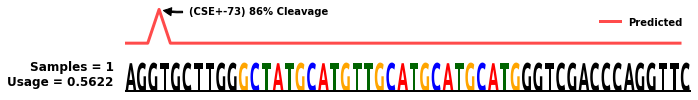

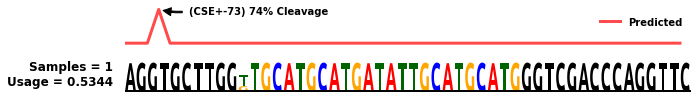

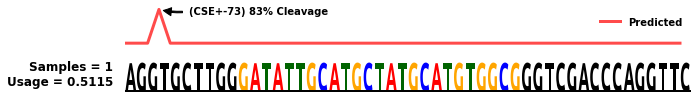

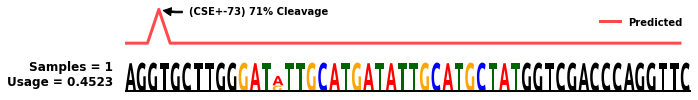

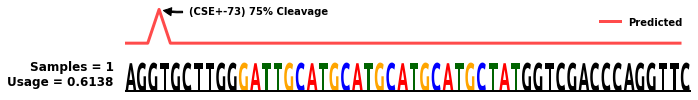

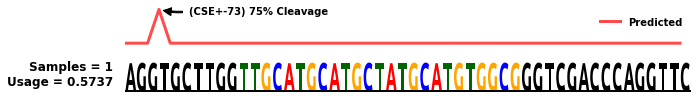

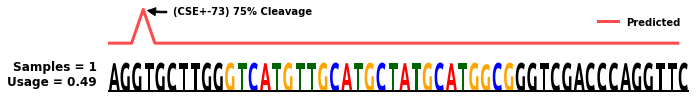

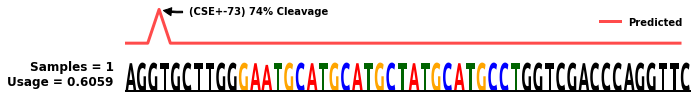

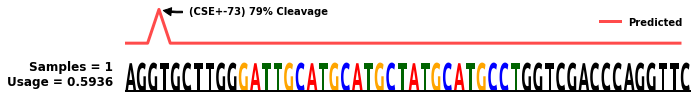

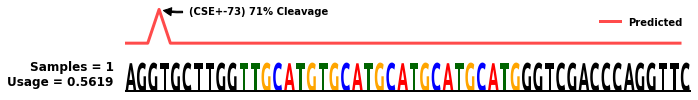

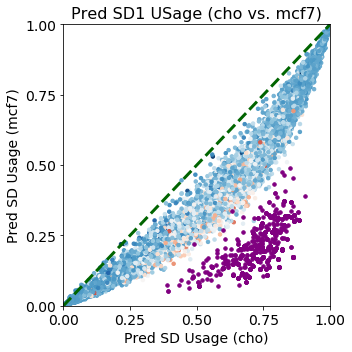

Cell type suffix = cho_vs_mcf7
Model suffix = _fix_punish_hexamers


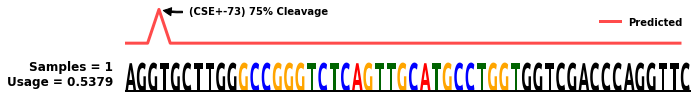

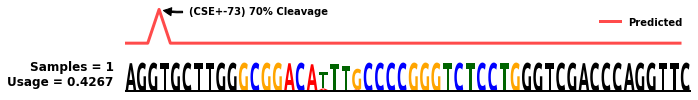

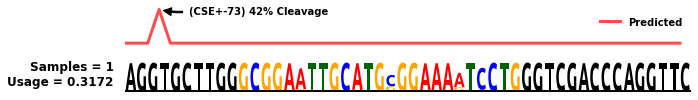

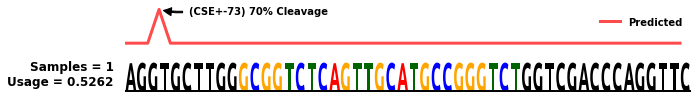

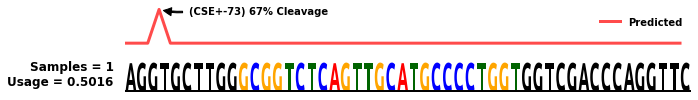

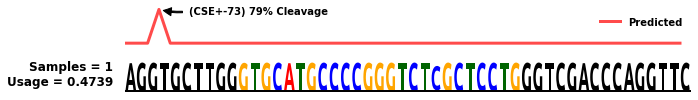

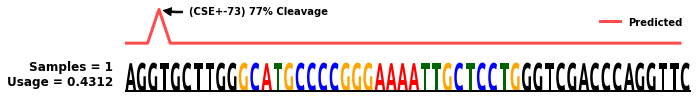

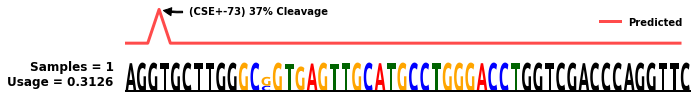

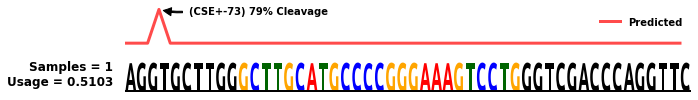

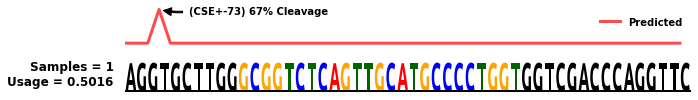

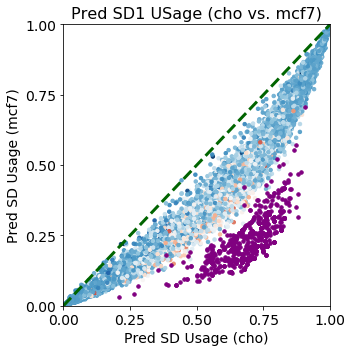

Cell type suffix = cho_vs_mcf7
Model suffix = _fix_punish_fourmers


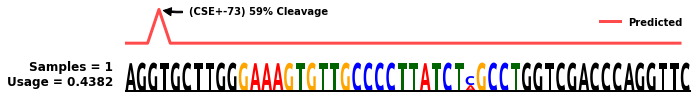

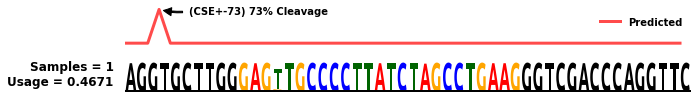

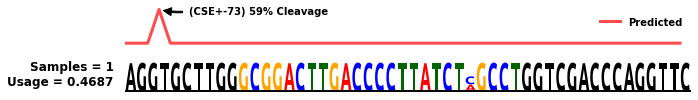

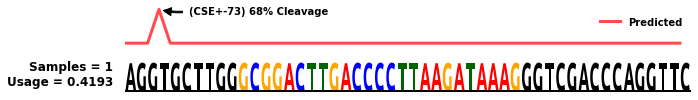

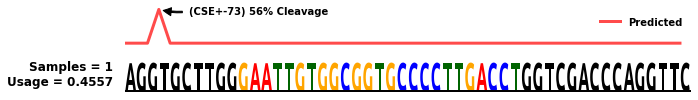

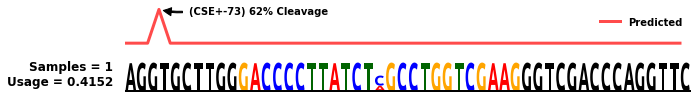

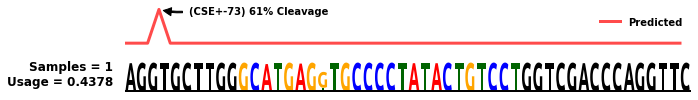

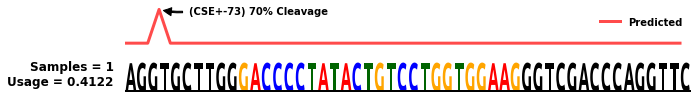

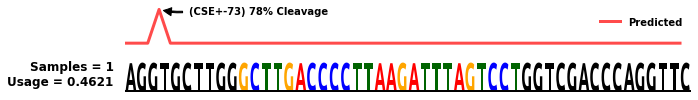

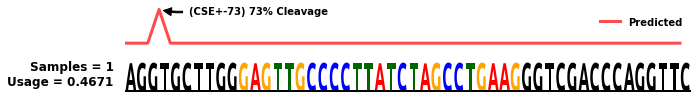

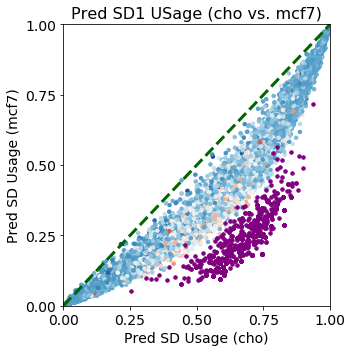

In [5]:
#Evaluate a collection of trained generators

pred_df = test_df

sequence_templates = [
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGGGACGACATTGATAAGGAAGGGGAGGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGGGACGACATTGATAAGGAAGGGGAGGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGGGACGACATTGATAAGGAAGGGGAGGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

cell_type_suffixes = [
    'cho_vs_mcf7',
    'cho_vs_mcf7',
    'cho_vs_mcf7'
]

cell_type_indices = [
    [3, 2],
    [3, 2],
    [3, 2]
]

model_suffixes = [
    '_fix',
    '_fix_punish_hexamers',
    '_fix_punish_fourmers'
]

save_figs = False

for model_i in range(len(sequence_templates)) :
    
    print('Cell type suffix = ' + str(cell_type_suffixes[model_i]))
    print('Model suffix = ' + str(model_suffixes[model_i]))

    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = 'genesis_diff_splicing_pwm_and_multisample_' + cell_type_suffixes[model_i] + model_suffixes[model_i] + '_generator.h5'
    model_path = os.path.join(save_dir, model_name)

    generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = 'genesis_diff_splicing_pwm_and_multisample_' + cell_type_suffixes[model_i] + model_suffixes[model_i] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
    
    cell_i, cell_j = cell_type_indices[model_i][0], cell_type_indices[model_i][1]
    
    n = 32

    sequence_class = np.array([0] * n).reshape(-1, 1)

    noise_1 = np.random.uniform(-1, 1, (n, 100))
    noise_2 = np.random.uniform(-1, 1, (n, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

    _, _, _, optimized_pwm, _, _, _, _, _, _, _, _, iso_pred = pred_outputs

    cut_pred = np.zeros((n, 1, 109))
    cut_pred[:, 0, 3] = iso_pred[:, 0, cell_i]

    diff_pred = iso_pred[:, :, cell_i] - iso_pred[:, :, cell_j]

    for pwm_index in range(10) :
        sequence_template = sequence_templates[sequence_class[pwm_index, 0]]

        pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
        cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
        iso = np.expand_dims(diff_pred[pwm_index, :], axis=-1)

        plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=50, save_figs=save_figs, fig_name="diff_splicing_genesis_logistic_regression_celltypes_" + cell_type_suffixes[model_i] + model_suffixes[model_i] + "_pwm_index_" + str(pwm_index), fig_dpi=150)
    
    n = 1024

    sequence_class = np.array([0] * n).reshape(-1, 1)

    noise_1 = np.random.uniform(-1, 1, (n, 100))
    noise_2 = np.random.uniform(-1, 1, (n, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

    _, _, _, optimized_pwm, _, _, _, _, _, _, _, _, iso_pred = pred_outputs


    cell_1, cell_2 = cell_type_suffixes[model_i].split("_vs_")

    f = plt.figure(figsize=(5, 5))

    min_delta = np.min(pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1])
    max_delta = np.max(pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1])
    max_abs_delta = np.abs(np.max(pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1]))

    plt.scatter(pred_df['sd1_pred_' + cell_1], pred_df['sd1_pred_' + cell_2], c=pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1], cmap='RdBu', vmin=min_delta, vmax=max_delta, s=12, alpha=0.95)

    plt.plot([0, 1], [0, 1], color='darkgreen', linewidth=3, linestyle='--')

    #Plot optimized dots
    plt.scatter(iso_pred[:1000, 0, cell_i], iso_pred[:1000, 0, cell_j], c='purple', s=12, alpha=1.0)

    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.xlabel('Pred SD Usage (' + cell_1 + ')', fontsize=14)
    plt.ylabel('Pred SD Usage (' + cell_2 + ')', fontsize=14)
    plt.title('Pred SD1 USage (' + cell_1 + ' vs. ' + cell_2 +')', fontsize=16)

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.tight_layout()
    
    if save_figs :
        fig_name = "diff_splicing_genesis_logistic_regression_celltypes_" + cell_type_suffixes[model_i] + model_suffixes[model_i] + "_pred_scatter"    
        plt.savefig(fig_name + ".png", transparent=True, dpi=150)
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
    
    plt.show()
